### Discovery of interesting peak-gene pairs

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import anndata as ad
import requests

In [3]:
# load data
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')
atac_adata.var.index = atac_adata.var.index.map(lambda peak: peak[9:])
atac_adata.var.index.name = 'Peak'
gene_locations = pd.read_table('./data/gene_locations_hg38.tsv', index_col = 'Gene ID', usecols = ['Gene ID', 'Begin', 'End', 'Chromosome', 'Symbol', 'Gene Type', 'Accession'])
gene_locations.drop(index = [idx for idx, accession in gene_locations['Accession'].items() if not accession.startswith('NC')], inplace = True)

#### Prior knowledge validation

Based on prior heart studies in mice, we expect to see:
- Periostin (Postn) expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 peaks to increase with TAC and decrease with TAC+JQ1
  - This data is human so peaks will likely not be 1:1 with mice data

In [4]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

diverging_palette = 'vlag'
hue_norm = lambda: mpl.colors.SymLogNorm(1)
sm = lambda hnorm: plt.cm.ScalarMappable(cmap=diverging_palette, norm=hnorm)

In [5]:
# boxplot of expression over organ/condition
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

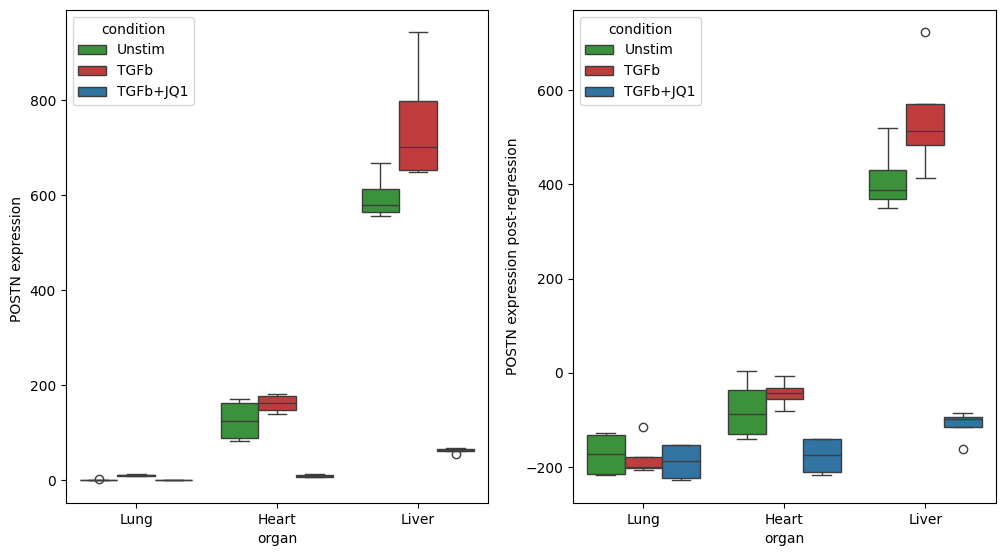

In [6]:
# Periostin expression pre- and post-regression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'POSTN', ax=ax1)
plot_expression(rna_adata, gene = 'POSTN', layer = 'post-regression', ax=ax2)
plt.show()

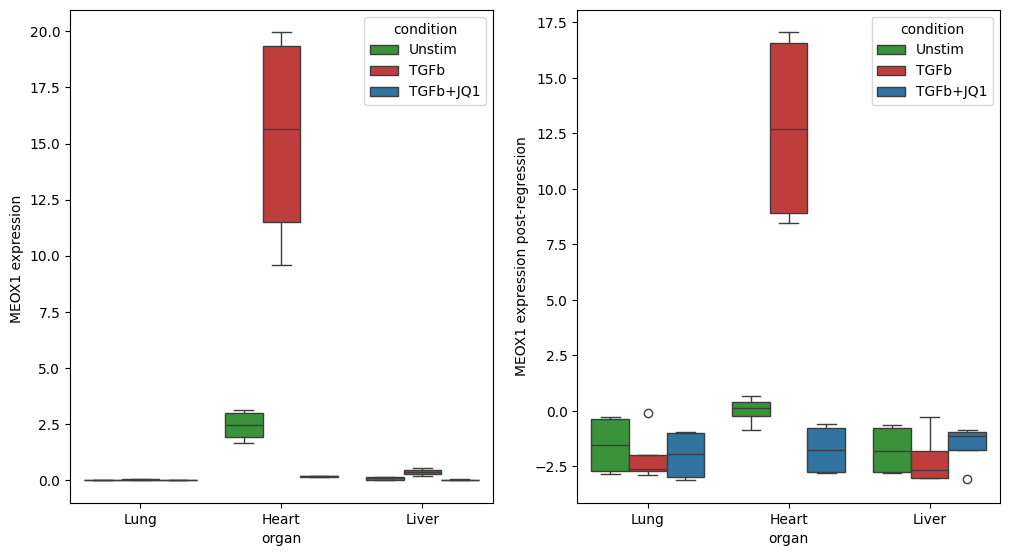

In [7]:
# MEOX1 expression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'MEOX1', ax=ax1)
plot_expression(rna_adata, gene = 'MEOX1', layer = 'post-regression', ax=ax2)
plt.show()

In [8]:
# heatmap of atac peaks over location range. also boxes the (approximate) gene location
def plot_peak_range(adata: ad.AnnData, chr: int, loc: tuple[float, float], layer: str = None, range = 1.5 * 10 ** 5, **kwargs) -> plt.Axes:
  peak_adata = adata[:, (adata.var['Chr'] == f'chr{chr}') & (adata.var['End'] >= loc[0] - range) & (adata.var['Start'] <= loc[1] + range)]
  peak_heatmap_df = pd.DataFrame({
    f"{organ}-{condition}": {
      peak: np.mean(peak_adata[rows.index, peak]._get_X(layer = layer)) for peak in peak_adata.var_names
    }
    for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
  }, dtype = 'float64')
  peak_heatmap_df = peak_heatmap_df[[f"{organ}-{condition}" for organ in markers.keys() for condition in palette.keys()]]
  ax = sns.heatmap(peak_heatmap_df, cmap = 'viridis', **kwargs)
  ax.set_ylabel("Peak")
  ax.set_xlabel("Organ-Condition")
  coding_index = peak_adata[:, (peak_adata.var['End'] >= loc[0]) & (peak_adata.var['Start'] <= loc[1])].var_names
  ax.add_patch(plt.Rectangle((0, peak_heatmap_df.index.get_loc(coding_index[0])), len(peak_heatmap_df.columns), len(coding_index), fill=False, edgecolor='crimson', lw=2, clip_on=False))
  return ax

In [9]:
meox1_row = gene_locations[gene_locations['Symbol'] == 'MEOX1']
meox1_row

,Accession,Begin,End,Chromosome,Symbol,Gene Type
Gene ID,,,,,,
4222,NC_000017.11,43640389,43661922,17,MEOX1,protein-coding


In [10]:
meox1_row[['Begin', 'End']].values[0]

array([43640389, 43661922])

/scratch/ipykernel_2592015/2366565480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])


/scratch/ipykernel_2592015/2366565480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])


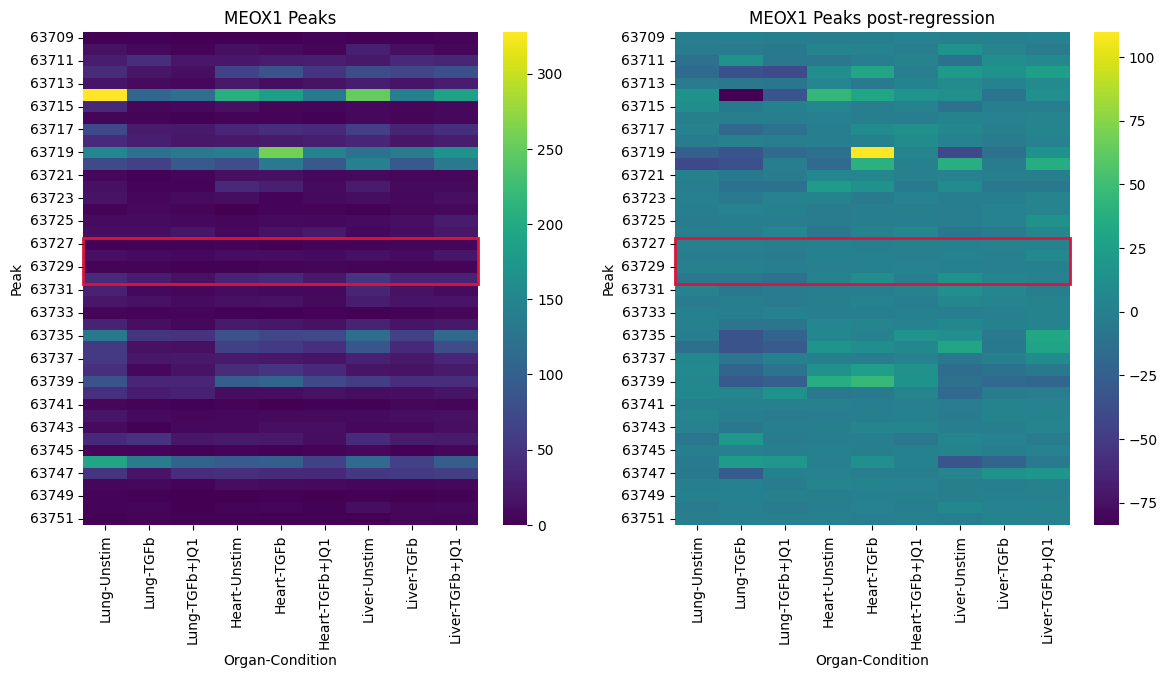

In [11]:
# MEOX1 peaks (Location according to UCSC is chr17, 43.64 - 43.66 Mb, expanding 150kb on either end)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6.4))
plot_peak_range(atac_adata, chr=meox1_row['Chromosome'].values[0], loc=meox1_row[['Begin', 'End']].values[0], ax=ax1)
ax1.set_title("MEOX1 Peaks")
plot_peak_range(atac_adata, chr=meox1_row['Chromosome'].values[0], loc=meox1_row[['Begin', 'End']].values[0], ax=ax2, layer='post-regression')
ax2.set_title("MEOX1 Peaks post-regression")
plt.show()

In [12]:
# chr17:43,616,437-43,616,691 <- orthologous to mouse peak 5
# chr17:43,616,835-43,617,184 <- orthologous to mouse peak 5
# not captured in this data
atac_adata[:, ['63723', '63724']].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63723,chr17,43614858,43615602,+,745
63724,chr17,43622133,43622721,+,589


In [13]:
# chr17:43,591,770-43,592,120 <- orthologous to mouse peak 10
# chr17:43,592,215-43,592,517 <- orthologous to mouse peak 9
# 63720 seems to bridge both of these intervals
atac_adata[:, '63720'].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63720,chr17,43591191,43592816,+,1626


In [14]:
# chr17:43,577,707-43,577,887 <- orthologous to mouse peak 13
# chr17:43,578,079-43,578,427 <- orthologous to mouse peak 13
# chr17:43,578,441-43,578,702 <- orthologous to mouse peak 13
# regions seem to be directly flanking
atac_adata[:, ['63718', '63719']].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63718,chr17,43576650,43577072,+,423
63719,chr17,43578751,43580003,+,1253


In [15]:
# boxplot of peak over organ/condition
def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{peak} consensus peaks {layer if layer is not None else ""}')
  return ax

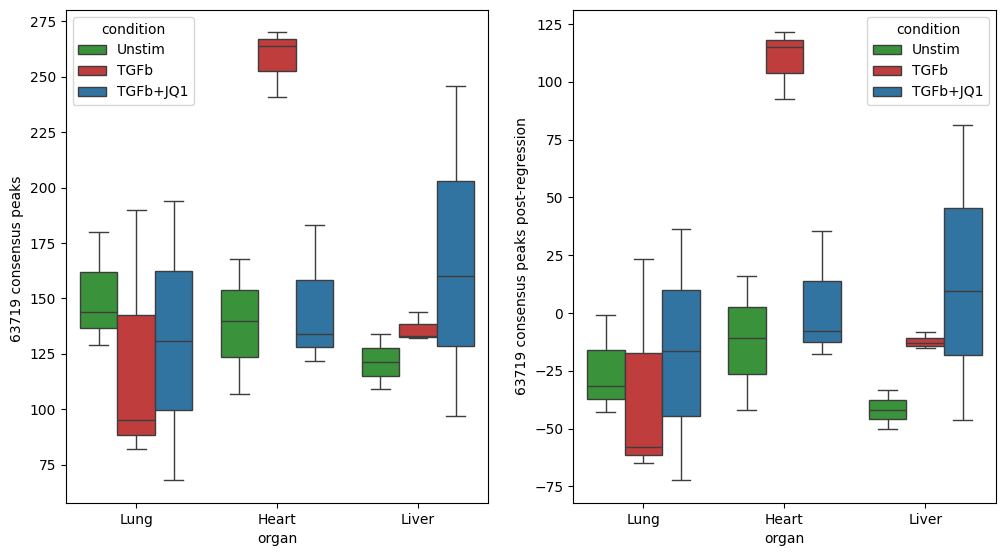

In [16]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63719', ax=ax1)
plot_peak(atac_adata, peak = '63719', ax=ax2, layer = 'post-regression')
plt.show()

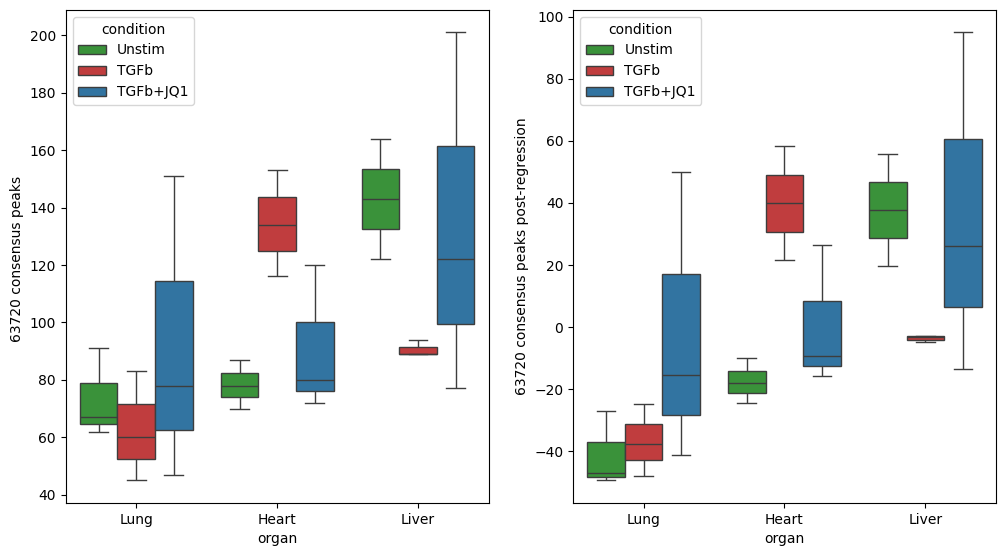

In [17]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63720', ax=ax1)
plot_peak(atac_adata, peak = '63720', ax=ax2, layer = 'post-regression')
plt.show()

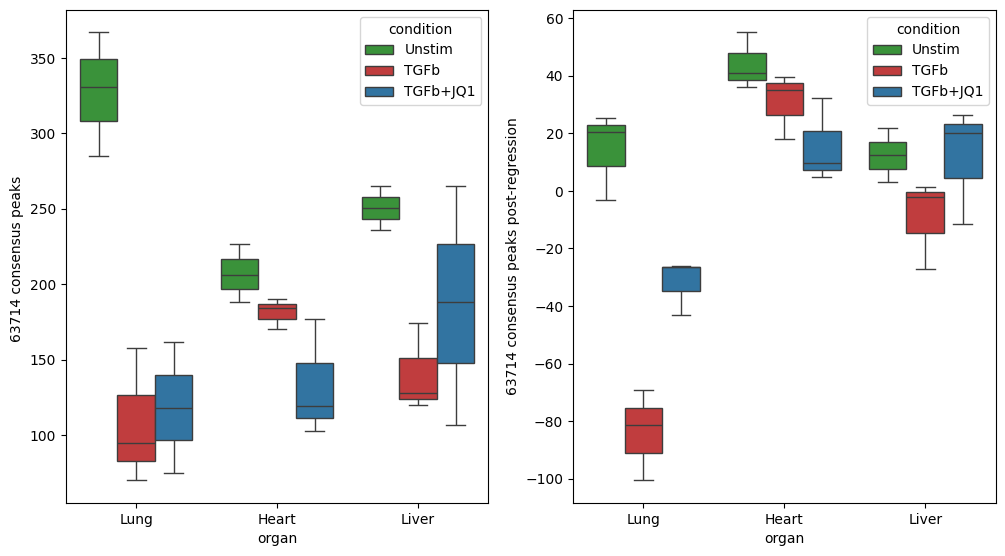

In [18]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63714', ax=ax1)
plot_peak(atac_adata, peak = '63714', ax=ax2, layer = 'post-regression')
plt.show()

### Methodology for identifying interesting peak-gene pairs
1. In one organ, identify genes with increased expression in TGFb and reduced in Unstim/JQ1.
2. For each gene, look within 150kb of TSS and identify peaks that show the same pattern across conditions.
3. Repeat steps 1 and 2 for each organ.
4. Compare/contrast peak-gene pairs across organs.
    - Can we identify organ-specific genes/enhancers?
    - Can we identify shared genes/enhancers?

Start by deep diving on heart!

In [19]:
def calc_condition_gene_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  condition_avg_df = organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates
  condition_avg_df['gene'] = organ_adata.var['gene']
  return condition_avg_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

Scores calculated by the following formula (sign-adjusted):
$$s = \log_2(1 + \text{TGFb}) * \log_2\frac{\text{TGFb}}{\text{Unstim}} * \log_2\frac{\text{TGFb+JQ1}}{\text{TGFb}}$$

Performed for both RNA and ATAC data. 0-vals replaced by 0.0001 to avoid divide by 0.

In [ ]:
def calc_lfc(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  odf_copy = organ_df.where(organ_df >= 0.0001, 0.0001)
  lfc_df = pd.DataFrame({
    'up': np.sqrt(np.log2(1 + odf_copy['TGFb'])) * np.log2(odf_copy['TGFb'] / odf_copy['Unstim'].where(odf_copy['Unstim'].gt(0.0001), 0.0001)),
    'down': np.sqrt(np.log2(1 + odf_copy['TGFb'])) * np.log2(odf_copy['TGFb+JQ1'] / odf_copy['TGFb'].where(odf_copy['TGFb'].gt(0.0001), 0.0001)),
  })
  all_zero = organ_df['Unstim'].eq(0.0) | organ_df['TGFb'].eq(0.0) | organ_df['TGFb+JQ1'].eq(0.0)
  lfc_df = lfc_df[~all_zero]
  lfc_df['score'] = (np.sign(lfc_df['down']) - np.sign(lfc_df['up'])) * lfc_df['up'] * lfc_df['down']
  return lfc_df

In [155]:
def calc_lfc(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  odf_copy = organ_df + 1
  lfc_df = pd.DataFrame({
    'up': np.sqrt(np.log2(odf_copy['TGFb'])) * np.log2(odf_copy['TGFb'] / odf_copy['Unstim']),
    'down': np.sqrt(np.log2(odf_copy['TGFb'])) * np.log2(odf_copy['TGFb+JQ1'] / odf_copy['TGFb']),
  })
  # all_zero = organ_df['Unstim'].eq(0.0) | organ_df['TGFb'].eq(0.0) | organ_df['TGFb+JQ1'].eq(0.0)
  # lfc_df = lfc_df[~all_zero]
  lfc_df['score'] = (np.sign(lfc_df['down']) - np.sign(lfc_df['up'])) * lfc_df['up'] * lfc_df['down']
  return lfc_df

In [156]:
def find_organ_genes(organ_df: pd.DataFrame, up_by: int = 0, down_by: int = 0) -> list[str]:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  upreg_genes = organ_df.index[(np.log2(organ_df['TGFb'] / organ_df['Unstim']) > up_by) & (np.log2(organ_df['TGFb+JQ1'] / organ_df['TGFb']) < down_by)]
  return upreg_genes

In [157]:
heart_rna_df = calc_condition_gene_averages(rna_adata, "Heart")
heart_rna_df.head()

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
A1BG,1.130977,0.974347,1.287053
A1BG-AS1,1.837193,3.606701,1.548569
A1CF,0.001390,0.001376,0.000000
A2M,0.021714,0.005007,0.036045
A2M-AS1,0.107994,0.023121,0.074854


In [158]:
heart_gene_lfc_df = calc_lfc(heart_rna_df)
heart_gene_lfc_df.head()

,up,down,score
gene,,,
A1BG,-0.106538,-1.150692e-01,0.000000e+00
A1BG-AS1,0.189844,8.577007e-01,0.000000e+00
A1CF,0.000090,-9.190372e-07,1.648901e-10
A2M,-0.003538,-4.187290e-03,0.000000e+00
A2M-AS1,0.016851,-4.422347e-02,1.490380e-03


In [159]:
def plot_lfc(lfc_df: pd.DataFrame, label: bool = False, **kwargs) -> plt.Axes:
  hnorm = hue_norm()
  if 'hue' not in kwargs:
    kwargs['hue'] = 'score'
    kwargs['palette'] = diverging_palette
    kwargs['hue_norm'] = hnorm
  ax = sns.scatterplot(lfc_df, x = 'up', y = 'down', legend=None, **kwargs)
  if label:
    for (idx, point) in lfc_df.iterrows():
      plt.text(point['up'], point['down'], idx, size='small')
  plt.xlabel("LFC(add TGFb)")
  plt.ylabel("LFC(add JQ1)")
  plt.axhline(0, linestyle='--', color = "lightgray")
  plt.axvline(0, linestyle='--', color = "lightgray")
  plt.autoscale(False)
  if type(kwargs['hue']) == str and kwargs['hue'] == 'score':
    legend_ax = ax.figure.add_axes((0.93, 0.15, 0.02, 0.7))
    legend_ax.figure.colorbar(sm(hnorm), cax=legend_ax)
  return ax

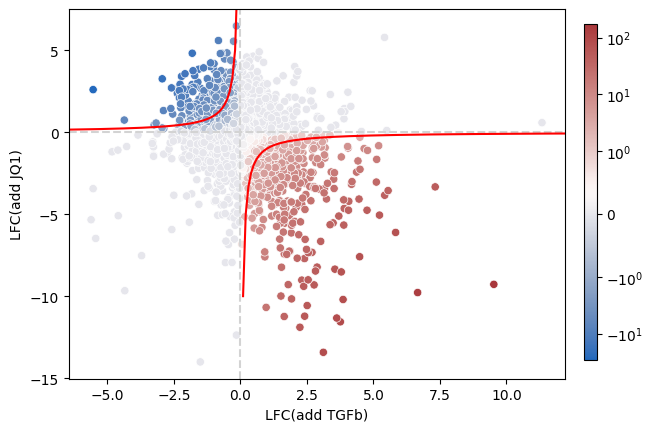

In [160]:
x = np.linspace(-100, 100, 2001)
with np.errstate(divide='ignore', invalid='ignore'):
  y = 1 / -x

ax = plot_lfc(heart_gene_lfc_df)
ax.plot(x, y, color = "red")
plt.show()

In [161]:
heart_rna_df.loc[['POSTN', 'MEOX1']]

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
POSTN,162.404112,9.646059,126.615900
MEOX1,15.216120,0.173933,2.444118


In [162]:
heart_gene_lfc_df['score'][['POSTN', 'MEOX1']]

gene
POSTN    20.662398
MEOX1    68.064090
Name: score, dtype: float64

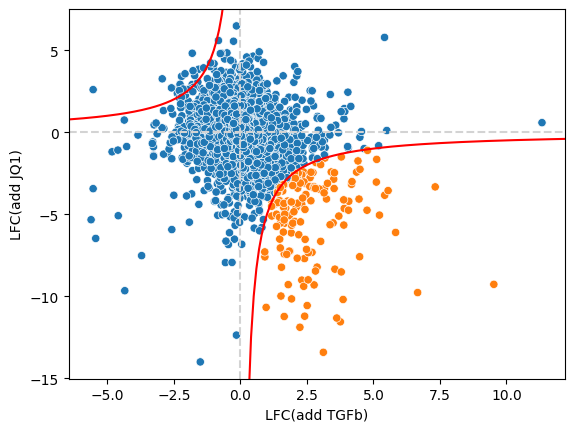

In [ ]:
with np.errstate(divide='ignore', invalid='ignore'):
  y = 5 / -x

ax = plot_lfc(heart_gene_lfc_df, hue = heart_gene_lfc_df['score'] > 10)
ax.plot(x, y, color = "red")
plt.show()

In [169]:
def calc_condition_peak_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  return organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates

In [170]:
heart_atac_df = calc_condition_peak_averages(atac_adata, "Heart")

In [171]:
def peaks_for_good_genes(gene_lfc_df: pd.DataFrame, avg_peak_df: pd.DataFrame) -> dict[str, pd.DataFrame]:
  gene_to_peaks = {}
  for gene in gene_lfc_df.index:
    if not any(gene_locations['Symbol'] == gene):
      continue
    if sum(gene_locations['Symbol'] == gene) > 1:
      print(gene_locations.loc[gene_locations['Symbol'] == gene])
      continue
    chr, begin, end = gene_locations.loc[gene_locations['Symbol'] == gene][['Chromosome', 'Begin', 'End']].to_numpy().flatten()
    # chr, begin, end = row['Chromosome'], row['Begin'], row['End']
    peak_locs = atac_adata.var_names[
                                  (atac_adata.var['Chr'] == f'chr{chr}') & 
                                  (atac_adata.var['End'] >= begin - 1.5 * 10 ** 5) & 
                                  (atac_adata.var['Start'] <= end + 1.5 * 10 ** 5)]
    gene_subset_df = avg_peak_df.loc[peak_locs]
    peak_lfc_df = calc_lfc(gene_subset_df)
    gene_to_peaks[gene] = peak_lfc_df
  return gene_to_peaks

In [172]:
heart_gene_to_peaks = peaks_for_good_genes(heart_gene_lfc_df[heart_gene_lfc_df['score'] > 1], heart_atac_df)


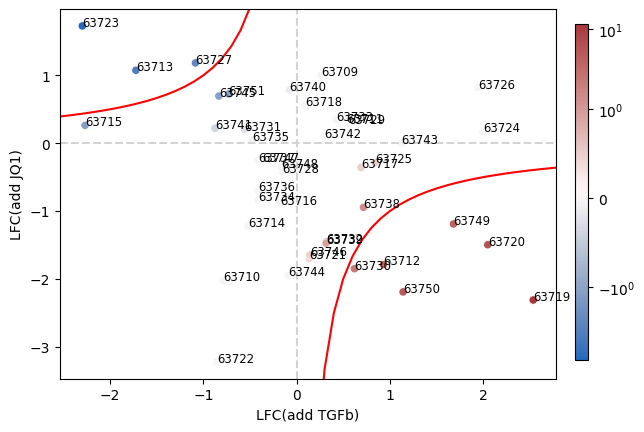

In [173]:
with np.errstate(divide='ignore', invalid='ignore'):
  y = 1 / -x

ax = plot_lfc(heart_gene_to_peaks['MEOX1'], label = True)
ax.plot(x, y, color = "red")
plt.show()

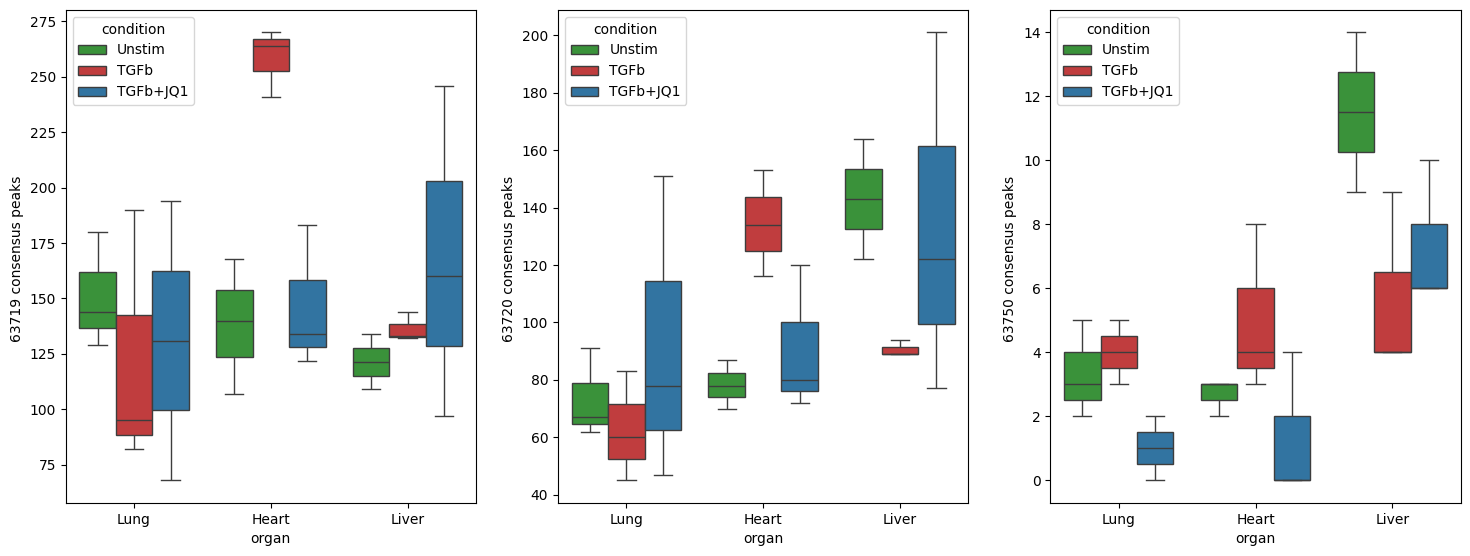

In [174]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 6.4))
plot_peak(atac_adata, peak = '63719', ax=ax1)
plot_peak(atac_adata, peak = '63720', ax=ax2)
plot_peak(atac_adata, peak = '63750', ax=ax3)
plt.show()

In [175]:
def merge_gene_peak_lfc(gene_lfc_df: pd.DataFrame, gene_to_peak_lfc_df: dict[str, pd.DataFrame]) -> pd.DataFrame:
  gene_peak_pair_df = pd.concat(gene_to_peak_lfc_df.values(), keys=gene_to_peak_lfc_df.keys())
  gene_peak_pair_df.index.names = ['Gene', 'Peak']
  gene_peak_pair_df['gene_score'] = gene_lfc_df['score'][gene_peak_pair_df.index.get_level_values(0)].values
  gene_peak_pair_df['peak_score'] = gene_peak_pair_df['score']
  gene_peak_pair_df = gene_peak_pair_df.drop(columns = ['up', 'down', 'score'])
  gene_peak_pair_df = gene_peak_pair_df[gene_peak_pair_df['peak_score'] > 1]
  gene_peak_pair_df = gene_peak_pair_df.sort_values(['gene_score', 'peak_score'], ascending=False)
  return gene_peak_pair_df

In [176]:
def get_best_pg_pairs(gene_peak_pair_df: pd.DataFrame) -> list[tuple[str, str]]:
  max_gene_score, max_peak_score = gene_peak_pair_df.max()
  peak_coeff = max_gene_score / max_peak_score
  boundary = max_gene_score / 2
  return [(gene, gene_peak_pair_df.loc[gene, :].index[0]) for gene in gene_peak_pair_df.index.get_level_values(0).unique() if (gene_peak_pair_df.loc[gene, :]['gene_score'] + peak_coeff * gene_peak_pair_df.loc[gene, :]['peak_score'] > boundary).any()]

In [177]:
heart_gene_peak_pair_df = merge_gene_peak_lfc(heart_gene_lfc_df, heart_gene_to_peaks)
best_heart_peaks = get_best_pg_pairs(heart_gene_peak_pair_df)

In [178]:
def plot_pg_pairs(gene_peak_pair_df: pd.DataFrame, best_peaks: list[tuple[str, str]], **kwargs) -> plt.Axes: 
  ax = sns.scatterplot(gene_peak_pair_df, x = 'gene_score', y = 'peak_score', hue = gene_peak_pair_df.index.isin(best_peaks), legend = None, **kwargs)
  for (gene, peak) in best_peaks:
    point = gene_peak_pair_df.loc[(gene, peak)]
    ax.text(point['gene_score'], point['peak_score'], f'{gene}-{peak}', size='x-small', va='bottom')
  return ax

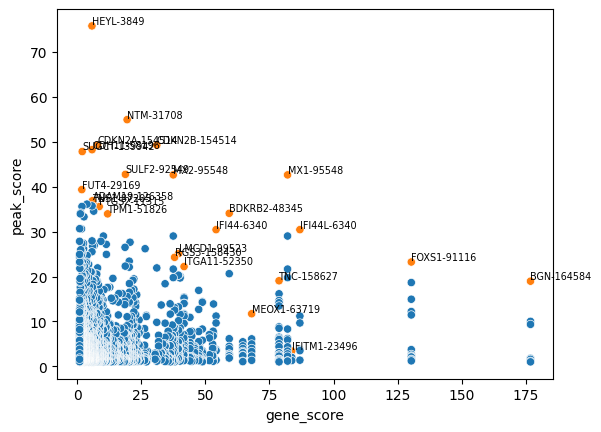

In [179]:
plot_pg_pairs(heart_gene_peak_pair_df, best_heart_peaks)
plt.show()

### Combining across organs

In [180]:
def run_organ_analysis(organ: str, layer: str = None) -> pd.DataFrame:
  organ_rna_df = calc_condition_gene_averages(rna_adata, organ, layer = layer)
  organ_gene_lfc_df = calc_lfc(organ_rna_df)
  organ_atac_df = calc_condition_peak_averages(atac_adata, organ, layer = layer)
  organ_gene_to_peaks = peaks_for_good_genes(organ_gene_lfc_df[organ_gene_lfc_df['score'] > 1], organ_atac_df)
  organ_gene_peak_pair_df = merge_gene_peak_lfc(organ_gene_lfc_df, organ_gene_to_peaks)
  return organ_gene_peak_pair_df

In [181]:
organ_to_all_pg_pairs = {
  organ: run_organ_analysis(organ) for organ in markers.keys()
}

            Accession    Begin      End Chromosome Symbol       Gene Type
Gene ID                                                                  
4267     NC_000023.11  2691295  2741309          X   CD99  protein-coding
4267     NC_000024.10  2691295  2741309          Y   CD99  protein-coding


In [182]:
organ_to_best_pairs = {
  organ: get_best_pg_pairs(organ_to_all_pg_pairs[organ]) for organ in markers.keys()
}

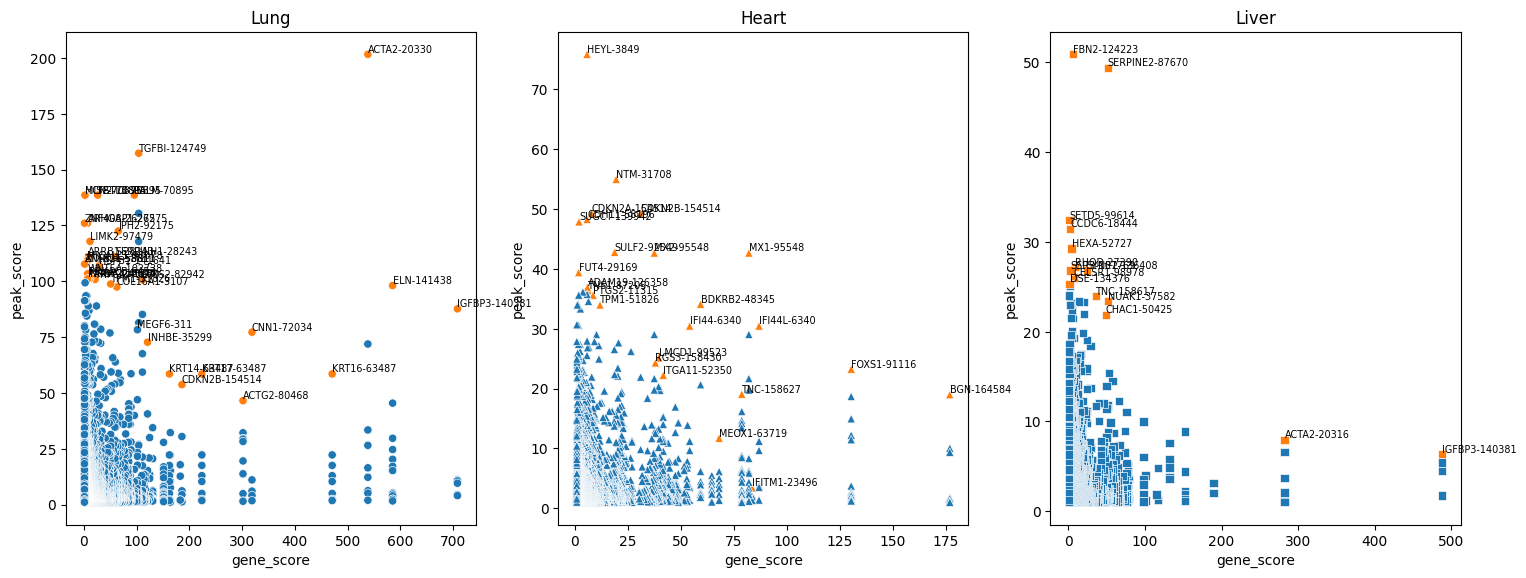

In [183]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(organ_to_all_pg_pairs[organ], organ_to_best_pairs[organ], ax=ax, marker=markers[organ])
  ax.set_title(organ)
plt.show()

In [184]:
combined_score_df = pd.concat(organ_to_all_pg_pairs.values(), axis = 'columns', keys = organ_to_all_pg_pairs.keys())
combined_score_df = combined_score_df.fillna(0.)
combined_score_df.to_csv('./data/pg_pairs.csv')
combined_score_df

Lung                 Heart                  Liver  \
                 gene_score peak_score gene_score peak_score  gene_score   
Gene     Peak                                                              
IGFBP3   140381  708.189963  87.634944   0.000000   0.000000  488.011034   
         140389  708.189963  11.152523   3.697923   1.200698  488.011034   
         140392  708.189963  10.763757   0.000000   0.000000    0.000000   
         140394  708.189963  10.577232   0.000000   0.000000  488.011034   
         140391  708.189963   9.559711   3.697923   1.301216    0.000000   
...                     ...        ...        ...        ...         ...   
NCOA7    134754    0.000000   0.000000   0.000000   0.000000    1.003757   
         134714    0.000000   0.000000   0.000000   0.000000    1.003757   
SNAR-A11 75072     0.000000   0.000000   0.000000   0.000000    1.003508   
RHOQ     78843     0.000000   0.000000   0.000000   0.000000    1.000949   
         78872     0.000000   0.000000   0.000000   0.000000    1.000949   

                            
                peak_score  
Gene     Peak               
IGFBP3   140381   6.354737  
         140389   5.419039  
         140392   0.000000  
         140394   1.755160  
         140391   0.000000  
...                    ...  
NCOA7    134754   1.270841  
         134714   1.084689  
SNAR-A11 75072    1.635600  
RHOQ     78843    6.308145  
         78872    2.047416  

[13138 rows x 6 columns]

In [185]:
pairs_in_all = combined_score_df[~combined_score_df.lt(5.0).any(axis=1)].index

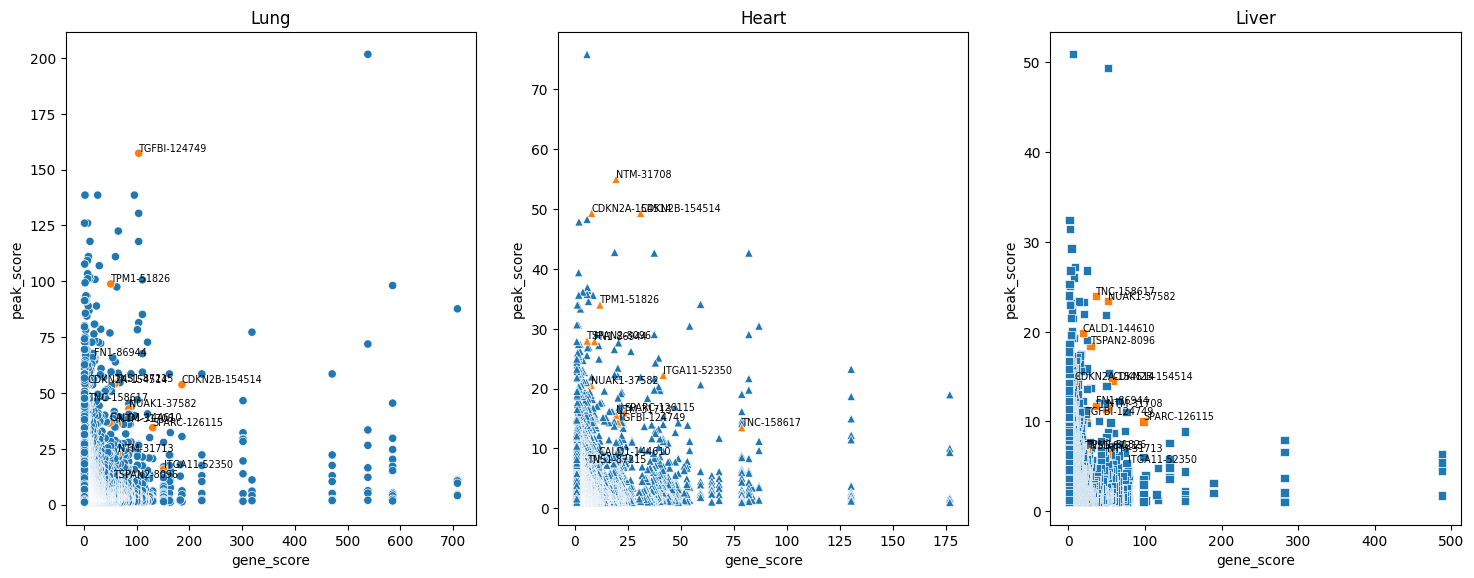

In [186]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(organ_to_all_pg_pairs[organ], pairs_in_all, ax=ax, marker=markers[organ])
  ax.set_title(organ)
plt.show()

### Determine Gene Functions

Cross-reference genes with [PantherDB](https://pantherdb.org/)/Gene Ontology to determine gene functional enrichment.

Cross-reference peaks with [Screen 2.0](https://screen.wenglab.org/) to determine previously identified cCREs. Ask Pawel - any recommendation for database to search for functional annotations of these cCREs?

In [197]:
def functional_enrichment(gene_list: list[str]):
  query = {
    'organism': 9606,  # human
    'annotDataSet': 'GO:0008150',  # gene ontology for biological processes
    'geneInputList': ','.join(gene_list)
  }
  request = requests.post(
    "https://pantherdb.org/services/oai/pantherdb/enrich/overrep", 
    params=query
  )
  if request.status_code != 200:
      raise Exception("Query failed. Status code: {}.".format(request.status_code))
  result = request.json()
  enriched_functions = result['results']['result']
  return [(func['term']['label'], func['pValue']) for func in enriched_functions if func['pValue'] < 0.001]

In [188]:
def get_screen_cCREs(peak_list: pd.DataFrame):
  variables = {
    "coordinates": [{ "chromosome": row['Chr'], "start": row["Start"], "end": row["End"] } for _idx, row in peak_list.iterrows()],
    "assembly": "grch38"
  }
  query = """
  query cCRESCREENSearch($assembly: String!, $coordinates: [GenomicRangeInput], ) { 
    cCRESCREENSearch(assembly: $assembly, coordinates: $coordinates) {
        info {
          accession
        }
        chrom
        start
        len
        pct     
        ctcf_zscore
        dnase_zscore
        atac_zscore
        enhancer_zscore
        promoter_zscore
      }
  }
  """
  request = requests.post(
      'https://factorbook.api.wenglab.org/graphql',
      json={ 'query': query, 'variables': variables },
      headers={}
  )
  if request.status_code != 200:
      raise Exception("Query failed. Status code: {}.".format(request.status_code))
  result = request.json()
  cCREs = sorted(result['data']['cCRESCREENSearch'], key = lambda cCRE: cCRE['enhancer_zscore'], reverse = True)
  return [(cCRE['info']['accession'], cCRE['enhancer_zscore']) for cCRE in cCREs if cCRE['enhancer_zscore'] > 3.1]

In [189]:
def get_functions_and_cCREs(pairs: list[tuple[str, str]]):
  functions = functional_enrichment([gene for gene, _peak in pairs])
  cCREs = get_screen_cCREs(atac_adata.var.loc[[peak for _gene, peak in pairs]])
  return functions, cCREs

In [198]:
common_functions, common_cCREs = get_functions_and_cCREs(pairs_in_all)

In [199]:
common_functions

[('regulation of cell adhesion', 4.401405749558809e-06),
 ('cell adhesion', 1.3358813559139571e-05),
 ('regulation of cell population proliferation', 2.4555758387415375e-05),
 ('cellular response to nutrient', 0.00028344461247758204),
 ('cell-substrate junction assembly', 0.0002978740765153584),
 ('cell-substrate junction organization', 0.00032779106851176144),
 ('regulation of cell morphogenesis', 0.000441616616562795),
 ('cell differentiation', 0.0005704574133165874),
 ('cellular developmental process', 0.0005737507642555285),
 ('regulation of cyclin-dependent protein serine/threonine kinase activity',
  0.0005764690071143813),
 ('regulation of cyclin-dependent protein kinase activity',
  0.0006175663681693202),
 ('positive regulation of heart rate by epinephrine', 0.0006316812439698251),
 ('tube morphogenesis', 0.0006955569964312693),
 ('negative regulation of cell adhesion', 0.000720430529960246),
 ('cellular senescence', 0.0007263577193751045),
 ('negative regulation of cell popul

In [192]:
common_cCREs

[('EH38E1378511', 4.405422210693359),
 ('EH38E2832602', 4.37067174911499),
 ('EH38E2687392', 4.366672515869141),
 ('EH38E3671511', 4.194187164306641),
 ('EH38E2422085', 3.8380653858184814),
 ('EH38E3671512', 3.806516170501709),
 ('EH38E1768726', 3.5701792240142822),
 ('EH38E1773186', 3.5394020080566406),
 ('EH38E1773185', 3.538635730743408),
 ('EH38E4125675', 3.369689702987671),
 ('EH38E3138859', 3.245800733566284),
 ('EH38E3138857', 3.2340736389160156),
 ('EH38E3138858', 3.2278079986572266)]

In [193]:
for organ, pairs in organ_to_best_pairs.items():
  organ_functions, organ_cCREs = get_functions_and_cCREs(pairs)
  print(f'--- {organ:^10} ---')
  print(organ_functions)
  print(organ_cCREs)

---    Lung    ---
[('supramolecular fiber organization', 4.438989784811169e-07), ('tissue migration', 6.645665658330788e-07), ('cytoskeleton organization', 3.6742219137855173e-06), ('mesenchyme migration', 2.641021507278019e-05), ('tissue morphogenesis', 3.49799001950337e-05), ('multicellular organismal process', 4.885504441284199e-05), ('actomyosin structure organization', 4.904394432965404e-05), ('negative regulation of smooth muscle cell proliferation', 7.205885088405055e-05), ('regulation of smooth muscle cell proliferation', 7.677719590308213e-05), ('tissue development', 8.164212686741064e-05), ('keratinocyte differentiation', 8.814555405141029e-05), ('extracellular matrix organization', 9.060016935934485e-05), ('extracellular structure organization', 9.21329432432895e-05), ('animal organ development', 9.296963003052306e-05), ('external encapsulating structure organization', 9.368562964549513e-05), ('positive regulation of hematopoietic stem cell proliferation', 9.46832855129936e